In [1]:
%matplotlib inline

import missingno as msn
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_squared_error

from correlation import select_genes, select_genes_mic
from sklearn.model_selection import KFold
import sys, os, pickle, lightgbm as lgb
import numpy as np

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
clinical = pd.read_csv('data/clinical.tsv', sep='\t', index_col='ID')

genecount = pd.read_csv('data/gene_count.tsv', sep='\t', index_col='ID')

clinical_gene = clinical.join(genecount, how='inner')

clinical_gene.shape

(749, 27833)

In [3]:
fish_vars = [
    '13q14', '13q34', '17p13', '1q21', '11p15', '15q15', '19q13', '20q13', '21q22', '3q21',
    '5q31', '7q22', '9q33', 't_11_14_ccnd1', 't_12_14_ccnd2', 't_14_16_maf', 't_14_20_mafb',
    't_4_14_whsc1',  't_6_14_ccnd3', 't_8_14_mafa', 't_8_14_myc', 'hyperdiploid_flag']

In [4]:
clinical_description = {'variable': [], 'type': [], 'number of values': [], 'sample':[], 'nas': [], 'count': []}

selected_variables = []

for c in clinical.columns[2:]:
    
    if c in fish_vars or clinical_gene[c].dtype == 'object' or c == 'iss':
        continue
        
    selected_variables.append(c)    
    
    clinical_description['variable'].append(c)
    
    clinical_description['type'].append(str(clinical_gene[c].dtype))
    
    nvalues = len(clinical_gene[c].unique())
    
    clinical_description['number of values'].append(nvalues)
    
    clinical_description['nas'].append(clinical_gene[c].isnull().sum())
    
    clinical_description['count'].append((~clinical_gene[c].isnull()).sum())
    
    try:
        clinical_description['sample'].append(', '.join([str(v) for v in clinical_gene[c].unique()[:min(5, nvalues)]]))
        
    except:
        clinical_description['sample'].append(None)

clinical_description = pd.DataFrame(clinical_description)

clinical_description

,variable,type,number of values,sample,nas,count
0,cmmc,float64,361,"nan, 5913.0, 22169.0, 3864.0, 12438.0",363,386
1,percent_aneuploid,float64,250,"0.0, 11.0, 15.4, 18.3, 20.7",193,556
2,percent_plama_cells_bone_marrow,float64,347,"4.9, 6.0, 8.4, 9.6, 10.1",112,637
3,percent_plama_cells_peripherical_blood,float64,84,"0.0, 0.1, 0.6, 0.03, nan",112,637
4,creatinine,float64,262,"88.4, 123.76, 106.08, 55.692, 81.328",15,734
5,absolute_neutrophil,float64,320,"2.4, 2.3, 2.6, 2.5, 10.29",17,732
6,platelet,float64,276,"216.0, 188.0, 219.0, 215.0, 385.0",1,748
7,wbc_x10_10_9_l,float64,179,"5.2, 4.3, 4.0, 4.7, 12.4",112,637
8,bun,float64,85,"8.925, 11.424, 5.355, nan, 4.284",171,578
9,glucose,float64,143,"4.675, 4.785, 5.995, 6.27, 11.0",123,626


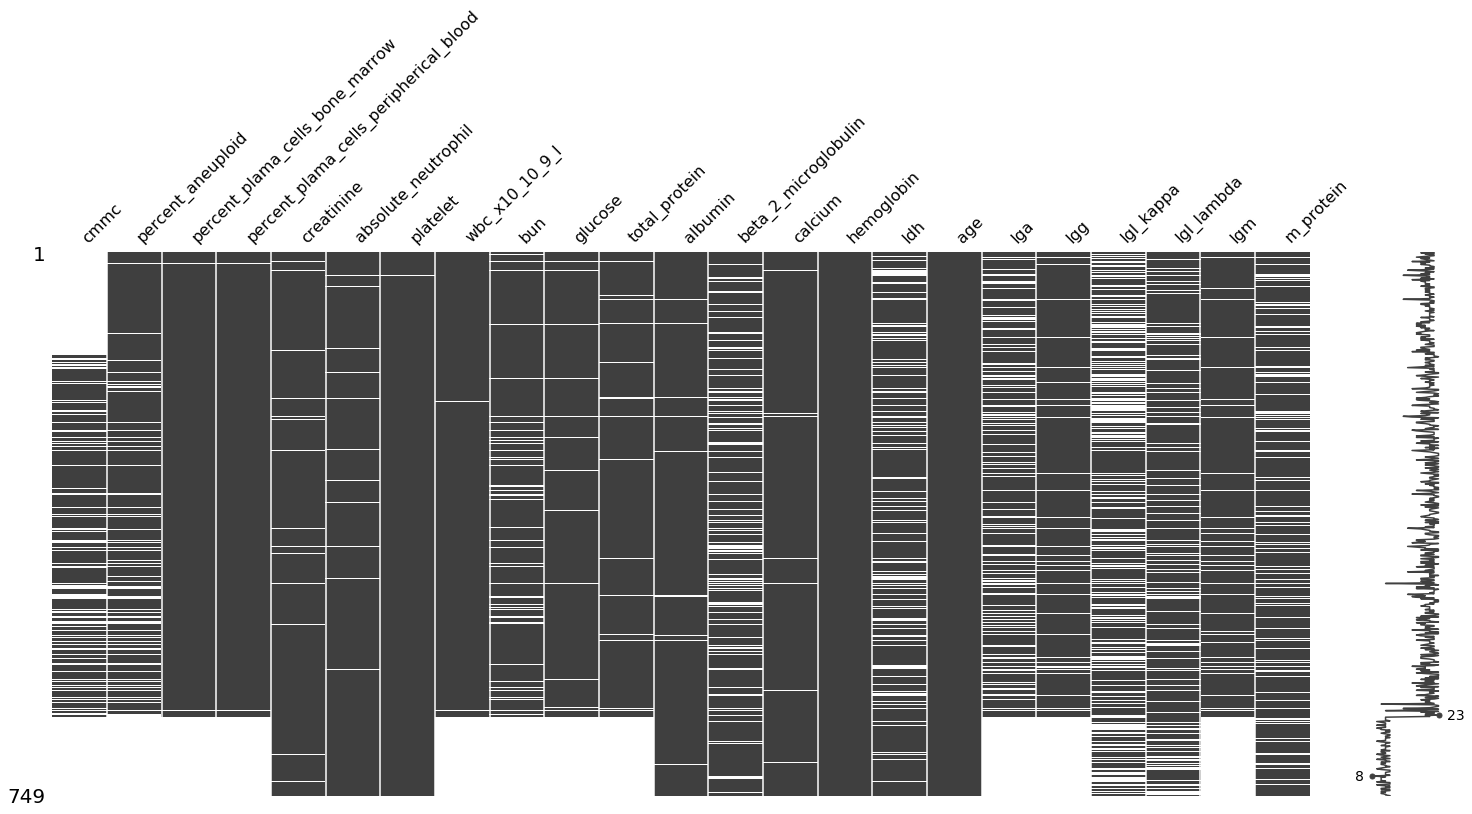

In [5]:
msn.matrix(clinical_gene[selected_variables]);

In [6]:
space  = [
    Real(1e-6, 9e-1, 'log-uniform', name='learning_rate'),
    Integer(7, 4095, name='num_leaves'),
    Integer(2, 100, name='max_depth'),
    Integer(1, 4000, name='scale_pos_weight'),
    Real(0.01, 1.5, name='min_child_weight'),
    Real(0.4, .9, name='colsample_bytree'),
    Real(0.001, 100, 'log-uniform', name='min_split_gain'),
    Integer(1, 50, name='min_child_samples'),
    Real(0.4, 0.9, name='subsample')]

def optimize_regression(x, y, space, n_calls=50):
    
    @use_named_args(space)
    def objective(num_leaves, max_depth, scale_pos_weight, min_child_weight, colsample_bytree, learning_rate,
                  min_split_gain, min_child_samples, subsample):
        
        scores = []

        params = {
            'learning_rate': learning_rate,
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'scale_pos_weight': int(scale_pos_weight),
            'min_child_weight': min_child_weight,
            'colsample_bytree': colsample_bytree,
            'min_split_gain': min_split_gain,
            'min_child_samples': int(min_child_samples),
            'subsample': subsample,
  
            'subsample_for_bin': 2,
            'objective': 'regression',
            'metric': 'rmse',
            'eval_metric': 'rmse',
            'is_unbalance':False,
            'nthread':24,          
            'verbose': -1}
        
        kf = KFold(5, shuffle=True, random_state=185) 
        
        for train_index, valid_index in kf.split(x, y[:,0]):
            
            lgb_train = lgb.Dataset(x[train_index,:], y[train_index,0])
            
            lgb_valid = lgb.Dataset(x[valid_index,:], y[valid_index,0])
            
            gbm = lgb.train(params, lgb_train, num_boost_round=1000,  
                            valid_sets=lgb_valid, early_stopping_rounds=100, verbose_eval=False) 
            
            y_hat = gbm.predict(x[valid_index,:], num_iteration=gbm.best_iteration, verbose_eval=False)

            scores.append(np.sqrt(mean_squared_error(y[valid_index, 0], y_hat)))
        
        return np.mean(scores)
    
    return gp_minimize(objective, space, n_calls=n_calls, random_state=22, verbose=False, n_jobs=-1)

In [18]:
clinical_gene_to_fill = clinical_gene[selected_variables].copy()

rmses = {'var': [], 'rmse': []}

for t in selected_variables:
    
    print('Filling variable {}'.format(t))
    
    try:
        
        continuous = clinical_gene[t]

        continuous_fill = continuous[~continuous.isnull()]
        continuous_unfill = continuous[continuous.isnull()]

        train = pd.DataFrame(continuous_fill).join(genecount, how='inner')
        valid = pd.DataFrame(continuous_unfill).join(genecount, how='inner')

        x_train, y_train = train.iloc[:,1:],train.iloc[:,[0]].apply(lambda x: np.log1p(x))
        x_valid, y_valid = valid.iloc[:,1:], valid.iloc[:,[0]]
        
        if x_valid.shape[0] < 10:
            print('Less than 10 empty values. Ignoring filling process for that variable\n')
            continue
        
        #
        #
        #
        file_name = 'output/fill/continuous_selected_genes_{}.pkl'.format(t)

        if os.path.exists(file_name):
            with open(file_name, 'rb') as file:
                selected_genes = pickle.load(file)

        else:
            
            print('Feature selection')

            selected_genes, mics = select_genes_mic(x_train, y_train.values[:,0], threshold=0.05)
            
            pd.DataFrame({'var': selected_genes, 'mic': mics}).to_csv(file_name.replace('pkl', 'csv'), sep=',', index=False)
            
            selected_genes = selected_genes[:min(500, len(selected_genes))]

            with open(file_name, 'wb') as file:
                pickle.dump(selected_genes, file)

        print('{} selected genes for translocation {}'.format(len(selected_genes), t))

        x_train, x_valid = x_train[selected_genes], x_valid[selected_genes]

        file_name = 'output/fill/continuous_{}.lgbm'.format(t)

        if os.path.exists(file_name):
            gbm = lgb.Booster(model_file=file_name)

        else:
            
            #
            # Optimization
            #
            print('Optimization')
            
            opt = optimize_regression(x_train.values, y_train.values, space, n_calls=10).x
            
            #
            # LightGBM
            #    
            print('Training')
            
            params = {
                'learning_rate': opt[0],
                'num_leaves': opt[1],
                'max_depth': opt[2],
                'scale_pos_weight': opt[3],
                'min_child_weight': opt[4],
                'colsample_bytree': opt[5],
                'min_split_gain': opt[6],
                'min_child_samples': opt[7],
                'subsample': opt[8],

                'subsample_for_bin': 2,
                'objective': 'regression',
                'metric': 'rmse',
                'eval_metric': 'rmse',
                'is_unbalance':False,
                'nthread':24,          
                'verbose': -1}
 
            opt_kf = KFold(5, shuffle=True, random_state=185) 
            
            for opt_train, opt_valid in opt_kf.split(x_train, y_train):
                
                lgb_train = lgb.Dataset(x_train.values[opt_train,:], y_train.values[opt_train, 0])
                
                lgb_valid = lgb.Dataset(x_train.values[opt_valid,:], y_train.values[opt_valid, 0])

                gbm = lgb.train(params, lgb_train, valid_sets=lgb_valid, num_boost_round=1000, 
                                early_stopping_rounds=100, verbose_eval=False)    
                
                rmse = np.sqrt(mean_squared_error(y_train.values[opt_train, 0], 
                                                 gbm.predict(x_train.values[opt_train,:])))
                
                rmses['var'].append(t)
                
                rmses['rmse'].append(rmse)
                
                break
            #
            #
            #
            gbm.save_model(file_name.format(t), num_iteration=gbm.best_iteration) 
        
        clinical_gene_to_fill.loc[continuous_unfill.index, t] = np.exp(gbm.predict(x_valid))
    
    except Exception as e:
        
        exc_type, exc_obj, exc_tb = sys.exc_info()
        
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        
        print('Some error with translocation {}: {} ({}, {}, {})'.format(t, e, exc_type, fname, exc_tb.tb_lineno))       
    
    print('')

rmses = pd.DataFrame(rmses)

rmses.to_csv('output/fill/accuracy_continuous_rmse.csv', sep=',', index=False)

rmses

Filling variable cmmc
459 selected genes for translocation cmmc
Optimization
Training

Filling variable percent_aneuploid
500 selected genes for translocation percent_aneuploid
Optimization
Training

Filling variable percent_plama_cells_bone_marrow
Feature selection
424 selected genes for translocation percent_plama_cells_bone_marrow
Optimization
Training

Filling variable percent_plama_cells_peripherical_blood
Feature selection
485 selected genes for translocation percent_plama_cells_peripherical_blood
Optimization
Training

Filling variable creatinine
Feature selection
500 selected genes for translocation creatinine
Optimization
Training

Filling variable absolute_neutrophil
Feature selection
500 selected genes for translocation absolute_neutrophil
Optimization
Training

Filling variable platelet
Less than 10 empty values. Ignoring filling process for that variable

Filling variable wbc_x10_10_9_l
Feature selection
500 selected genes for translocation wbc_x10_10_9_l
Optimization
Trai

,var,rmse
0,cmmc,1.658749
1,percent_aneuploid,1.225415
2,percent_plama_cells_bone_marrow,0.723004
3,percent_plama_cells_peripherical_blood,0.519951
4,creatinine,0.419655
5,absolute_neutrophil,0.391511
6,wbc_x10_10_9_l,0.322886
7,bun,0.411052
8,glucose,0.271422
9,total_protein,0.192490


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4c6f1a6a0>]],
      dtype=object)

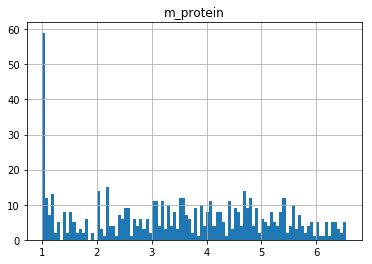

In [19]:
pd.DataFrame(np.exp(y_train)).hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc50cca9518>]],
      dtype=object)

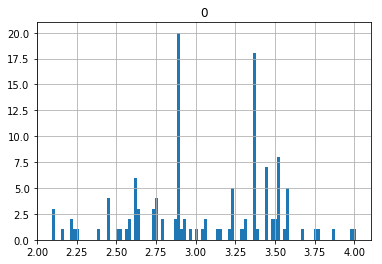

In [20]:
pd.DataFrame(np.exp(gbm.predict(x_valid))).hist(bins=100)

In [23]:
clinical_gene_to_fill['age'].unique()

array([54., 79., 46., 65., 62., 76., 64., 81., 69., 53., 58., 67., 45.,
       66., 47., 61., 49., 68., 82., 85., 48., 71., 59., 75., 70., 74.,
       36., 60., 80., 63., 78., 77., 56., 43., 84., 57., 39., 52., 40.,
       37., 55., 72., 83., 73., 32., 44., 31., 51., 41., 50., 27., 88.,
       42., 90., 86., 93., 38., 87.])